In [7]:
import os
import sys

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

PATH_SCA = os.path.join(p,'code/sca') 

sys.path.insert(0, PATH_SCA)

In [8]:
import numpy as np
import sklearn
import numpy.random as npr
from matplotlib import pyplot as plt
from scipy.linalg import orth
import time
import os
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
import matplotlib.patches as mpatches

from sca.models import fit_sca, weighted_pca, weighted_rrr
from sca.util import get_sample_weights
import shutil

SyntaxError: invalid syntax (models.py, line 91)

In [ ]:
rule_name    = {'reactgo': 'RT Go',
                'delaygo': 'Dly Go',
                'fdgo': 'Go',
                'delaydm1': 'Dly DM 1',
                'delaydm2': 'Dly DM 2',
                'contextdelaydm1': 'Ctx Dly DM 1',
                'contextdelaydm2': 'Ctx Dly DM 2',
                'multidelaydm': 'MultSen Dly DM',
                'reactanti': 'RT Anti',
                'delayanti': 'Dly Anti',
                'fdanti': 'Anti',
                'dmsgo': 'DMS',
                'dmsnogo': 'DNMS',
                'dmcgo': 'DMC',
                'dmcnogo': 'DNMC',
                'dmc': 'DMC'
                }

from scipy.cluster import hierarchy
all_epochs = ['stim1','stim2','delay1','delay2','go1']
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
            15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z',
           27:'a', 28:'b', 29:'c', 30:'d', 31:'e', 32:'f', 33:'g', 34:'h', 35:'i', 36:'j', 37:'k', 38:'l', 39:'m', 
            40:'n', 41:'o', 42:'p', 43:'q', 44:'r', 45:'s', 46:'t', 47:'u', 48:'v', 49:'w', 50:'x', 51:'y', 52:'z'}

def make_cluster_midpoint_labels(clust):
    d = np.concatenate(([-1], np.where(np.diff(clust))[0],[len(clust)-1]),axis = 0)
    mid = np.zeros(len(d))
    cluster_size = np.zeros(len(d))
    for xi in range(len(d)-1):
        cluster_size[xi] = d[xi+1] - d[xi]
        mid[xi] = d[xi+1]-cluster_size[xi]/2+.5
    return cluster_size, mid

feature_names_master = ['DMS delay1', 'DMS go1', 'RT Go go1', 'DMC go1', 'DNMC go1',
       'DNMS delay1', 'DNMS go1', 'Dly DM 2 stim2', 'Ctx Dly DM 2 stim2',
       'Dly DM 1 stim2', 'Ctx Dly DM 1 stim2', 'MultSen Dly DM stim2',
       'DMS stim1', 'DMC stim1', 'Go stim1', 'Dly Go stim1',
       'Ctx Dly DM 2 stim1', 'Ctx Dly DM 1 stim1', 'MultSen Dly DM stim1',
       'Dly DM 1 stim1', 'Dly DM 2 stim1', 'RT Anti go1', 'DMC delay1',
       'DNMC delay1', 'Anti stim1', 'Dly Anti stim1', 'DNMS stim1',
       'DNMC stim1', 'Ctx Dly DM 2 go1', 'Ctx Dly DM 1 go1',
       'MultSen Dly DM go1', 'Anti go1', 'Go go1', 'Dly DM 1 go1',
       'Dly DM 2 go1', 'Dly Go go1', 'Dly Anti go1',
       'MultSen Dly DM delay2', 'Ctx Dly DM 1 delay1',
       'MultSen Dly DM delay1', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
       'Ctx Dly DM 1 delay2', 'Ctx Dly DM 2 delay1',
       'Ctx Dly DM 2 delay2', 'Dly Anti delay1', 'Dly Go delay1',
       'Dly DM 1 delay2', 'Dly DM 2 delay2']

method = 'ward'
criterion = 'distance'
cel_max_d = 0
max_d = 0
normalization_method='max'

def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    
    
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']
task_name_dict = {}
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]

# feature_names_original = [tick_names[s] for s in range(len(tick_names))]
# feat_order = [feature_names_original.index(s) for i,s in enumerate(cluster_var['tick_names'])]
# X = D[:,feat_order]
# feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in cluster_var['tick_names']]
# task_labels = [task_name_dict[feat] for feat in feature_names_labels]

def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())
        xl = np.max(ax.get_xlim())

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)

In [ ]:
def plot_skree(sca_var,pca_var):

    fig = plt.figure(figsize=(3,3),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)

    plt.plot(np.cumsum(sca_var)/np.sum(np.var(X,axis = 0)),'-o',label = 'SCA')
    plt.plot(np.cumsum(pca_var)/np.sum(np.var(X,axis = 0)),'-o', label = 'PCA')
    plt.ylabel('Norm. Cumul. Var.')
    plt.xlabel('Latent #')
    plt.ylim([0,1])
    plt.legend()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca',save_m)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.savefig(os.path.join(save_dir,'var_explained'+'_nlatent'+str(R_est)+'.pdf'))

In [ ]:
def plot_latents(h_all,trial_all,active_units,R_est,model,U_est_pca,rule_sublist,save_m,ylim):

    n_latent = R_est
    for sca in [True,False]:

        fig = plt.figure(figsize=(1.2*len(rule_sublist),.9*n_latent),tight_layout=True,facecolor='white')
        fig = plt.figure(figsize=(2.5*len(rule_sublist),n_latent),tight_layout=True,facecolor='white')

        for ri in range(len(rule_sublist)):
            rule = rule_sublist[ri]

            if sca == True:
                latents = np.dot(h_all['by_rule'].item()[rule][:,:,active_units],model.fc2.weight.detach().numpy()) 
            else:
                latents = h_all['by_rule'].item()[rule][:,:,active_units]@U_est_pca

            n_time,n_trial,_ = np.shape(latents)

            ax = fig.add_subplot(n_latent,len(rule_sublist),ri+1)
            trial_in = trial_all[rule]
            plt.plot(range(len(trial_in)),trial_in[:,0,0],'s',markersize = 3)

            for stim_ind in range(2,6):
#                 plt.scatter(range(len(trial_in)),abs(trial_in[:,0,stim_ind])+.05,s = 10,c = np.zeros(len(trial_in)),
#                         cmap = 'hsv',alpha = .5,marker = 's')
                non_zero_inds = abs(trial_in[:,0,stim_ind])>min(abs(trial_in[:,0,stim_ind]))
                plt.scatter(range(len(non_zero_inds)),non_zero_inds+.05,s = 10,c = np.zeros(len(trial_in)),
                    cmap = 'hsv',alpha = .5,marker = 's')

            plt.plot(range(len(trial_in)),trial_in[:,0,4:]+.1,'s',markersize = 3)
#             trial_in[:,0,ri+5]+.1
            plt.ylim([.99, 1.2])

            ax.set_xticks([])
            if ri==0:
                ax.set_yticks([1,1.05,1.1])
                ax.set_yticklabels(['Fixation','Stimulus','Context'],fontsize = 9)
            else:
                ax.set_yticks([])

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            plt.title(rule_set_names[ri],fontsize = 11, y=1.0, pad=-8)

            subplot_counter = 0
            latent_set = range(1,n_latent+1) #[2,3,5,6,11,13,14] #[2,3,5,6,9,10,11,13,14,15,16] #
            n_vis_latents = len(latent_set)

            for x in latent_set:

                subplot_counter +=1

                ax = fig.add_subplot(n_latent+1,len(rule_sublist),subplot_counter*len(rule_sublist)+ri+1)

                colors = plt.cm.hsv(np.linspace(0, 1, n_trial))

                for ti in range(0,n_trial,4):

                    plt.plot(latents[:,ti,x-1], color=colors[ti],alpha = .8,linewidth = 1) 

                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_ylim([-ylim,ylim])
                    plt.axis('off')

        save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca',save_m)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        if sca == True:
            plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
        else:
            plt.savefig(os.path.join(save_dir,'pca_latents_penalty'+'_'+str(R_est)+'.pdf'))

In [6]:
def plot_atlas(sca_normvar_all,sca_cluster_var,pca_normvar_all,pca_cluster_var,tick_names):

    for sca in [True,False]:

        if sca==True:
            D = sca_normvar_all
            cluster_var = sca_cluster_var
        else:
            D = pca_normvar_all
            cluster_var = pca_cluster_var

        # D = h_normvar_all
        # cluster_var = h_cluster_var

        feature_names_original = [tick_names[s] for s in range(len(tick_names))]
        feat_order = [feature_names_original.index(s) for i,s in enumerate(cluster_var['tick_names'])]
        X = D[:,feat_order]
        feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in cluster_var['tick_names']]


        epoch_binary = {}
        for e_name in ['delay1','delay2','go1','stim1','stim2']:
            epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                                    feat_name in cluster_var['tick_names']]


        #visualize atlas for master network
        fig = plt.figure(figsize=(9,3),tight_layout=True,facecolor='white')
        plt.rcParams.update({'font.size': 16})
        legend_done = 0
        atlas_width = .55
        atlas_height = .55
        thresh = 1

        axdendro_top = fig.add_axes([.06,atlas_height+.092,atlas_width-.05,.07])
        Y = sch.linkage(X.T, method=method)
        clusters_top = fcluster(Y, thresh, criterion=criterion)
        Z_top = sch.dendrogram(Y, orientation='top',leaf_font_size = 11,color_threshold=thresh,
                               above_threshold_color='gray', labels = clusters_top)

        cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
        for xi in range(len(mid_top)-1):
            if cluster_size[xi]==1:
                c = 'k'
            else:
                color_ind = xi - np.sum(cluster_size[:xi]==1)
                c = color_palette[color_ind%len(color_palette)]
            clust_mid = mid_top[xi]
            rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,5, 
            fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
            plt.gca().add_patch(rect)
            plt.text(clust_mid*10,-2,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)
        #                         plt.text(xi*10,-15,str(clusters_sorted[int(xi)]))

        remove_spines(axdendro_top)
        remove_ticks(axdendro_top)
        axdendro_top.set_xticks([])

        axdendro = fig.add_axes([0,0,0.04,atlas_height])
        Y = sch.linkage(X, method=method)
        clusters = cluster_var['clusters']
        Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                           leaf_font_size = 11,color_threshold=0,above_threshold_color='gray', labels = clusters)

        cluster_size, mid = make_cluster_midpoint_labels(clusters)
        for xi in range(len(mid)-1):

            c = color_palette[xi%len(color_palette)]
            clust_mid = mid[xi]
            rect=mpatches.Rectangle((-5,5+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
            fill=True,
            color=c,facecolor=c,alpha = .1,clip_on=False)
            plt.gca().add_patch(rect)

        remove_spines(axdendro)
        remove_ticks(axdendro)
        axdendro.set_xticks([])


        axmatrix = fig.add_axes([.06,0,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
        index_top = Z['leaves'][::-1]
        X = X[index_top,:]
        plt.imshow(X,cmap= 'viridis', aspect='auto')

        len_te = len(feature_names_labels)
        axmatrix.set_xticks(range(len_te))
        task_labels = [task_name_dict[feat] for feat in feature_names_labels]
        axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
        #                     plot_epoch_labels(axmatrix,epoch_binary,which_axes = 'y',ms = 12.5)
        plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 8)

        # label_master_seed = ' '.join([rnn_type,activation,w_init]) 

        if sca==True:
            plt.text(-3,len(X)*1.5,r"$\bf{SCA \ Latents}$"+' \n (sorted by column similarity)',rotation = 90)
        else:
            plt.text(-3,len(X)*1.5,r"$\bf{PCA \ Latents}$"+' \n (sorted by column similarity)',rotation = 90)

        # plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master_seed.split()),rotation = 90)
        plt.text(2,-len(X)/2.5,r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
        axmatrix.xaxis.set_label_coords(.4, 1.29)
        remove_spines(axmatrix)
        axmatrix.set_yticks([])
        # plt.ylim((len(X)+1,0))

        # make subpanels.
        sp_width = .14
        sp_wide = .2
        offset = .06

        label = '_'.join([rnn_type,activation,w_init,str(seed),'nlatent'+str(R_est)])
        figname = 'atlas_'+label+'.pdf'

        figpath_full = os.path.join(save_dir,'atlas')
        if not os.path.exists(figpath_full):
            os.makedirs(figpath_full)

        if sca == True:
            plt.savefig(os.path.join(figpath_full,'sca_'+figname+'.pdf'),bbox_inches = 'tight')
            plt.savefig(os.path.join(figpath_full,'sca_'+figname+'.png'),bbox_inches = 'tight')
        else:
            plt.savefig(os.path.join(figpath_full,'pca_'+figname+'.pdf'),bbox_inches = 'tight')
            plt.savefig(os.path.join(figpath_full,'pca_'+figname+'.png'),bbox_inches = 'tight')

        plt.show()

        X_tile = np.tile(np.max(X,axis = 0),(R_est,1))
        X_diff = X_tile-X

        fig = plt.figure(figsize=(3,3),tight_layout=True,facecolor='white')
        plt.imshow(X_diff)
        plt.xlabel('Task Periods')

        if sca == True:
            sca_X_diff = X_diff
            plt.ylabel('SCA Latents')
        else:    
            pca_X_diff = X_diff
            plt.ylabel('PCA Latents')

        plt.colorbar(shrink = .35,label = 'Variance diff')

        if sca == True:
            plt.savefig(os.path.join(figpath_full,'sca_'+'variance_diff'+'.pdf'))
            plt.savefig(os.path.join(figpath_full,'sca_'+'variance_diff'+'.png'))
        else:
            plt.savefig(os.path.join(figpath_full,'pca_'+'variance_diff'+'.pdf'))
            plt.savefig(os.path.join(figpath_full,'pca_'+'variance_diff'+'.png'))
            
    return sca_X_diff,pca_X_diff


In [7]:
def make_dendro(D,tick_names,method = 'ward',criterion = 'distance',cel_max_d = 0,max_d = 0, 
                normalization_method='max',fig_width = 3,fig_height = 10):

    # Compute and plot dendrogram.
    fig = plt.figure(figsize=(fig_width, fig_height))
    axdendro = fig.add_axes([-0.65,0.1,0.2,0.75])

    Y = sch.linkage(D, method=method)

    if max_d==0:
        max_d = find_opt_clust_num(D,Y)
        clusters = fcluster(Y, max_d, criterion='maxclust')
    else:
        clusters = fcluster(Y, max_d, criterion=criterion)
        
        
    Z = sch.dendrogram(Y, orientation='left',labels = tick_names,
                       leaf_font_size = 11,color_threshold=max_d)

    axdendro.set_xticks([])
    axdendro.spines['top'].set_visible(False)
    axdendro.spines['right'].set_visible(False)
    axdendro.spines['bottom'].set_visible(False)
    axdendro.spines['left'].set_visible(False)

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.22,0.1,0.75,0.75])
    index_left = Z['leaves']
    tick_names_sorted = [tick_names[i] for i in index_left]
    D = D[index_left,:]

    # cel_num = [CA.ind_active[x] for x in index_top]
    axdendro_top = fig.add_axes([0.22,.9,0.75,0.1])
    Y = sch.linkage(D.T, method=method)
    if cel_max_d==0:
        lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_opt_clust'
        cel_max_d = find_opt_clust_num(D.T,Y)
        clusters = fcluster(Y, cel_max_d, criterion='maxclust')
    else:
        lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
        clusters = fcluster(Y, cel_max_d, criterion=criterion)
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=cel_max_d)

    # axdendro_top.set_xticks([])
    axdendro_top.set_yticks([])
    axdendro_top.spines['top'].set_visible(False)
    axdendro_top.spines['right'].set_visible(False)
    axdendro_top.spines['bottom'].set_visible(False)
    axdendro_top.spines['left'].set_visible(False)

    index_top = Z['leaves']
    D = D[:,index_top]
    clusters_sorted = clusters[index_top]
    im = axmatrix.matshow(D, aspect='auto', origin='lower',cmap='magma')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.985,0.1,0.03,0.8])
    plt.colorbar(im, cax=axcolor)

    lesion_units_list = [None]
    for il, l in enumerate(np.unique(clusters)):
        ind_l = np.where(clusters == l)[0]

    # save cluster variables
    cluster_var = {'D':D,'Z':Z,
                'index_top':index_top,
                'index_left':index_left,
                'tick_names':tick_names_sorted,
                'clusters':clusters_sorted,
                'lesion_units_list':lesion_units_list,
                'max_d':cel_max_d,
                'criterion':criterion,
                'method':method}

    return cluster_var


def find_opt_clust_num(D,Y):
    # Choose number of clusters that maximize silhouette score
    n_clusters = range(3, np.min([len(Y),40]))
    scores = list()
    labels_list = list()
    for n_cluster in n_clusters:
        clusters = fcluster(Y, n_cluster, criterion='maxclust')

        score = metrics.silhouette_score(D, clusters)

        scores.append(score)
        labels_list.append(clusters)

    scores = np.array(scores)
    max_d = np.argmax(scores)
    opt_clust = n_clusters[max_d]
    return opt_clust

Using lam_sparse=  0.033870048781521334
Using lam_orthog=  4218.544270833334
Using device cpu


  1%|▍                                        | 59/5000 [00:01<01:42, 48.19it/s]


KeyboardInterrupt: 

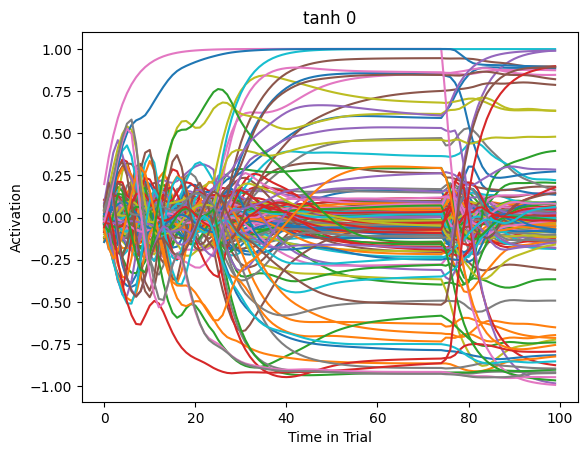

In [8]:
#N latents
R_est=10
R_sim=9

#order of tasks for plotting
rule_sublist = ['fdgo','delaygo','fdanti','delayanti','reactgo','reactanti']
rule_set_names = ['DelayPro', 'MemoryPro', 'DelayAnti', 'MemoryAnti', 'ReactPro', 'ReactAnti']

#Number of epochs of model fitting
n_epochs=5000

#Learning rate of model fitting
lr=.001

#Strength of the sparsity penalty
lam_sparse=.1

#Strength of the orthogonality penality (Note - This is only used in the version without a hard orthogonality constraint)
lam_orthog=1

#load task inputs
tanh_m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/tanh/diag/15_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff1.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
trial_all = np.load(os.path.join(tanh_m,'trial_all.npz'),encoding='bytes',allow_pickle=True)

#network params
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -8
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']
rule_trains_str = '_'.join(rule_trains)

rnn_type_set = ['LeakyRNN',]
activation_set = ['tanh','softplus']
w_init_set = ['diag',]
seed_set = [str(0),str(1),str(2)]

for rnn_type_i in [0,]:
    for activation_i in [0,1]:
        for w_init_i in [0,]:
            for seed in seed_set:
            
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                m = os.path.join(p,'sherlock/multitask-nets/stepnet/data/sca/',
                                 rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                 str(n_rnn)+'_n_rnn',net_name+'_'+rule_trains_str,str(seed))
                save_m = m[72:]
                save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca',save_m)

                #load network activations
                h_all = np.load(os.path.join(m,'h_all.npz'),encoding='bytes',allow_pickle=True)

                #concatenate activation for each task
                cat_h_all_by_rule = h_all['by_rule'].item()[rule_sublist[0]][:,0:-1:4,:]
                for rule in rule_sublist[1:]:
                    cat_h_all_by_rule = np.concatenate((cat_h_all_by_rule,h_all['by_rule'].item()[rule][:,0:-1:4,:]),axis = 0)

                cat_trials = np.reshape(np.transpose(cat_h_all_by_rule,(1,0,2)),(-1,128))

                #currently using all units
                active_units = np.argsort(np.var(cat_trials,axis = 0))#[:86] # active_units = np.var(cat_trials,axis = 0)>.05

                #plot activations
                plt.plot(cat_trials[:100,active_units],'-')
                plt.xlabel('Time in Trial')
                plt.ylabel('Activation')
                plt.title(activation+' '+str(seed))

                X0 = cat_trials[:,active_units]
                X=np.copy(X0-np.mean(X0,axis=0)[None,:])

                #How much to weight each data point in time
                #(this can be helpful for making sure dimensions still aim to explain time points with low activity)
                sample_weights=get_sample_weights(X) #Weight inversely to norm of activity at each time point

                #Fit weighted PCA
                #Note that this function does not automatically subtract the mean from the data (as in many PCA functions)
                U_est_pca,V_est_pca = weighted_pca(X,R_est,sample_weights)

                #Get the low dimensional representation (the principal components)
                pca_latent = X@U_est_pca
                pca_var = np.var(pca_latent,axis = 0)

                pca_latents = h_all['by_rule'].item()[rule][:,:,active_units]@U_est_pca
                n_time,n_trial,n_latent = np.shape(pca_latents)

                # Fit SCA with orthogonality penalty (rather than constraint) without all the optional parameters
                model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,n_epochs=n_epochs,sample_weight=sample_weights)

                #Get the low dimensional representation
                sca_latent=latent.detach().numpy()
                sca_var = np.var(sca_latent,axis = 0)

                #Plot the loss over all iterations
                plt.figure()
                plt.plot(losses)
                plt.xlabel('Training Epoch')
                plt.ylabel('Loss')
                plt.title('Loss over training')
                print(m)

                plot_skree(sca_var,pca_var)

                if activation=='tanh':
                    ylim = 5
                else:
                    ylim = 1.5

                plot_latents(h_all,trial_all,active_units,R_est,model,U_est_pca,rule_sublist,save_m,ylim)

                use = [key[0] in rule_sublist for key in h_all['by_epoch'].item().keys()]
                tick_names = [rule_name[key[0]]+' '+str(key[1])[1:][1:-1] for key in h_all['by_epoch'].item().keys()]
                ticks_use = [tick_names[x] for x in np.where(use)[0]]

                # _, _, n_units = np.shape(h_all['by_rule'].item()[rule])
                n_units = len(active_units)# np.sum(active_units>0)
                n_task_periods = np.sum(use) #len(h_all['by_epoch'].item().keys())

                h_var_all = np.zeros((n_units, n_task_periods))
                sca_var_all = np.zeros((n_latent, n_task_periods))
                pca_var_all = np.zeros((n_latent, n_task_periods))

                counter = 0
                for i, val in enumerate(h_all['by_epoch'].item().values()):
                    # val is Time, Batch, Units
                    # Variance across time and stimulus
                    # h_var_all[:, i] = val[t_start:].reshape((-1, n_hidden)).var(axis=0)
                    # Variance acros stimulus, then averaged across time

                    if use[i]==True:

                        active_val = val[:,:,active_units]

                        val_reshape = np.reshape(active_val,(-1,n_units))
                        h_var_all[:, counter] = val_reshape.var(axis = 0)

                        sca_val = np.dot(active_val,model.fc2.weight.detach().numpy())
                        sca_val_reshape = np.reshape(sca_val,(-1,n_latent))
                        sca_var_all[:, counter] = sca_val_reshape.var(axis = 0)

                        pca_val = active_val@U_est_pca
                        pca_val_reshape = np.reshape(pca_val,(-1,n_latent))
                        pca_var_all[:, counter] = pca_val_reshape.var(axis = 0)

                        counter+=1

                pca_normvar_all = (pca_var_all.T/np.max(pca_var_all, axis=1)).T
                D = pca_normvar_all.T
                pca_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0,
                                              max_d = 2,fig_width = 2.5,fig_height = 5)

                sca_normvar_all = (sca_var_all.T/np.max(sca_var_all, axis=1)).T
                D = sca_normvar_all.T
                sca_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0,
                                              max_d = 2,fig_width = 2.5,fig_height = 5)

                h_normvar_all = (h_var_all.T/np.max(h_var_all, axis=1)).T
                D = h_normvar_all.T
                h_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0,
                                            max_d = 0,fig_width = 2.5,fig_height = 5)

                sca_X_diff,pca_X_diff =  plot_atlas(sca_normvar_all,sca_cluster_var,pca_normvar_all,pca_cluster_var,tick_names)

                label = '_'.join([activation,'seed'+str(seed),'nlatent'+str(R_est)])
                save_dir = os.path.join('/Users/lauradriscoll/Documents/sca_new/',label)
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                
                # new var Josh asked for
                np.save(os.path.join(save_dir,'model_weights'),model.fc2.weight.detach().numpy())
                shutil.copy(os.path.join(m,'h_all.npz'), os.path.join(save_dir,'h_all.npz'))
                    
#                 #save atlas var
#                 atlas_var = {'pca_normvar_all':pca_normvar_all,
#                           'pca_cluster_var':pca_cluster_var,
#                           'sca_normvar_all':sca_normvar_all,
#                           'sca_cluster_var':sca_cluster_var,
#                           'h_normvar_all':h_normvar_all,
#                           'h_cluster_var':h_cluster_var}
                
#                 np.savez(os.path.join(save_dir,'atlas_var.npz'),**atlas_var)
                
                
#                 #save_sca var
#                 sca_var = {'cat_trials':cat_trials,
#                           'X':X,
#                           'latent':sca_latent}
                
#                 np.savez(os.path.join(save_dir,'sca_var.npz'),**sca_var)
                
#                 #Save Diff summary variables
#                 X_diff = {'sca':sca_X_diff,
#                           'pca':pca_X_diff}

#                 figname = 'X_diff_'+label

#                 np.savez(os.path.join(save_dir,figname+'.npz'),**X_diff)
# #                 np.savez(os.path.join(save_dir,'h_all.npz'),encoding='bytes',allow_pickle=True)



Using lam_sparse=  0.0729223044698791
Using lam_orthog=  28157.666666666668
Using device cpu


100%|███████████████████████████████████████| 5000/5000 [04:15<00:00, 19.53it/s]


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/tanh/diag/15_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff1.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0


/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'pca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications 

Using lam_sparse=  0.07943242883783061
Using lam_orthog=  30421.663194444445
Using device cpu


100%|███████████████████████████████████████| 5000/5000 [04:43<00:00, 17.64it/s]


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/tanh/diag/15_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff1.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1


/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'pca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications 

Using lam_sparse=  0.07990229287629147
Using lam_orthog=  30927.170138888887
Using device cpu


100%|███████████████████████████████████████| 5000/5000 [04:35<00:00, 18.13it/s]


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/tanh/diag/15_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff1.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2


/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:74: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'sca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.savefig(os.path.join(save_dir,'pca_latents_penalty'+'_'+str(R_est)+'.pdf'))
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_51095/3673362004.py:76: UserWarning: tight_layout not applied: number of rows in subplot specifications 

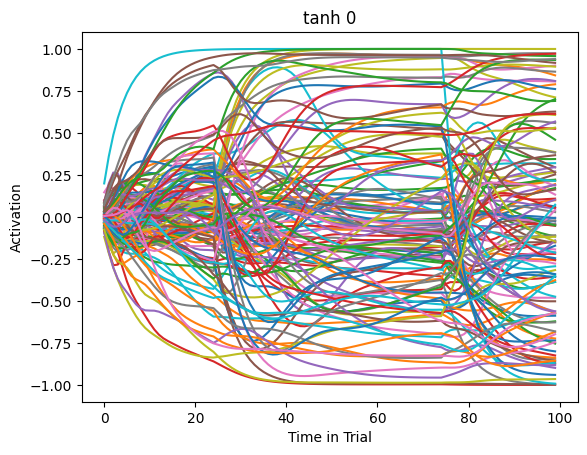

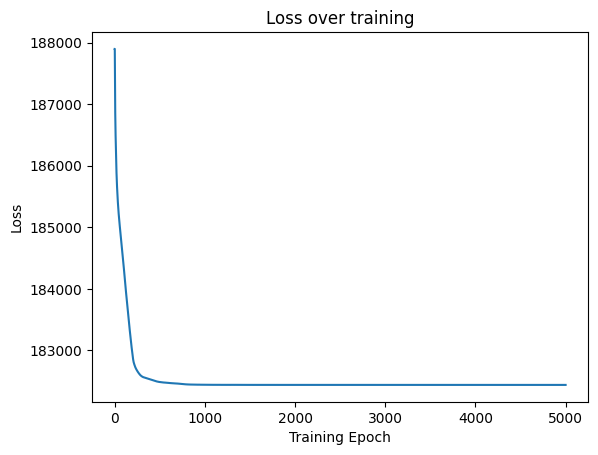

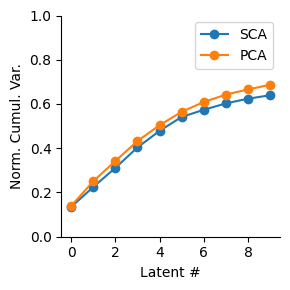

<Figure size 1800x900 with 0 Axes>

/usr/local/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


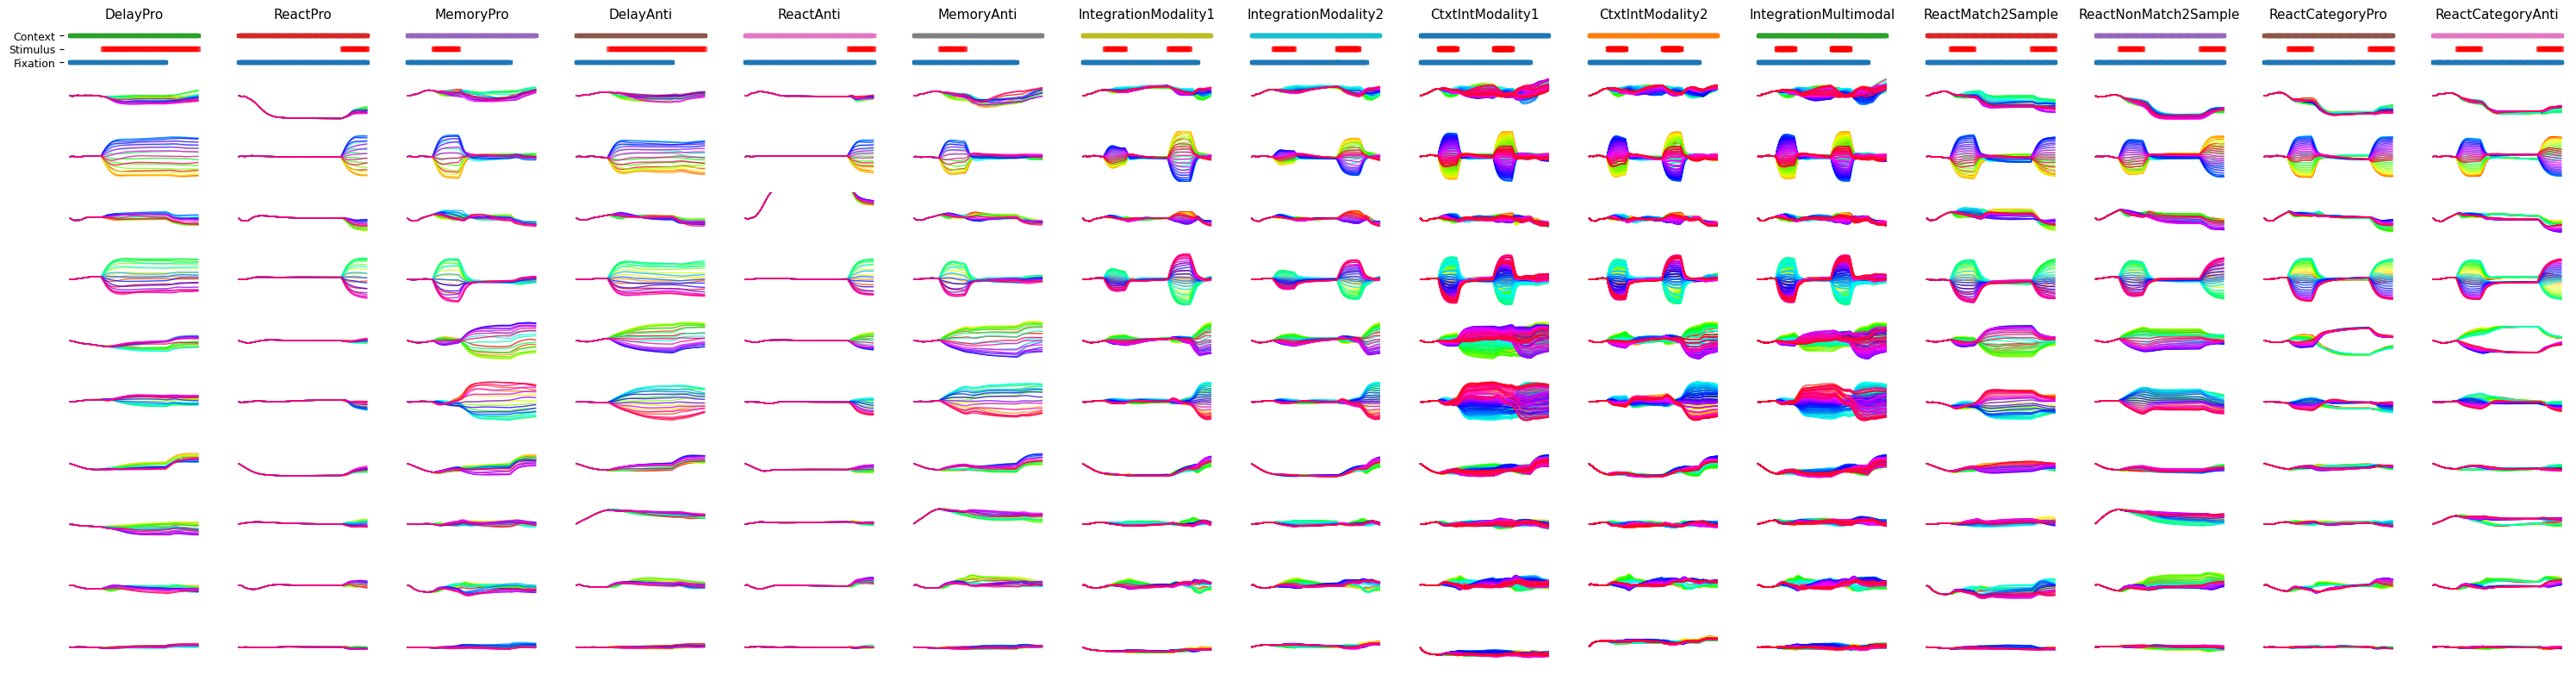

<Figure size 1800x900 with 0 Axes>

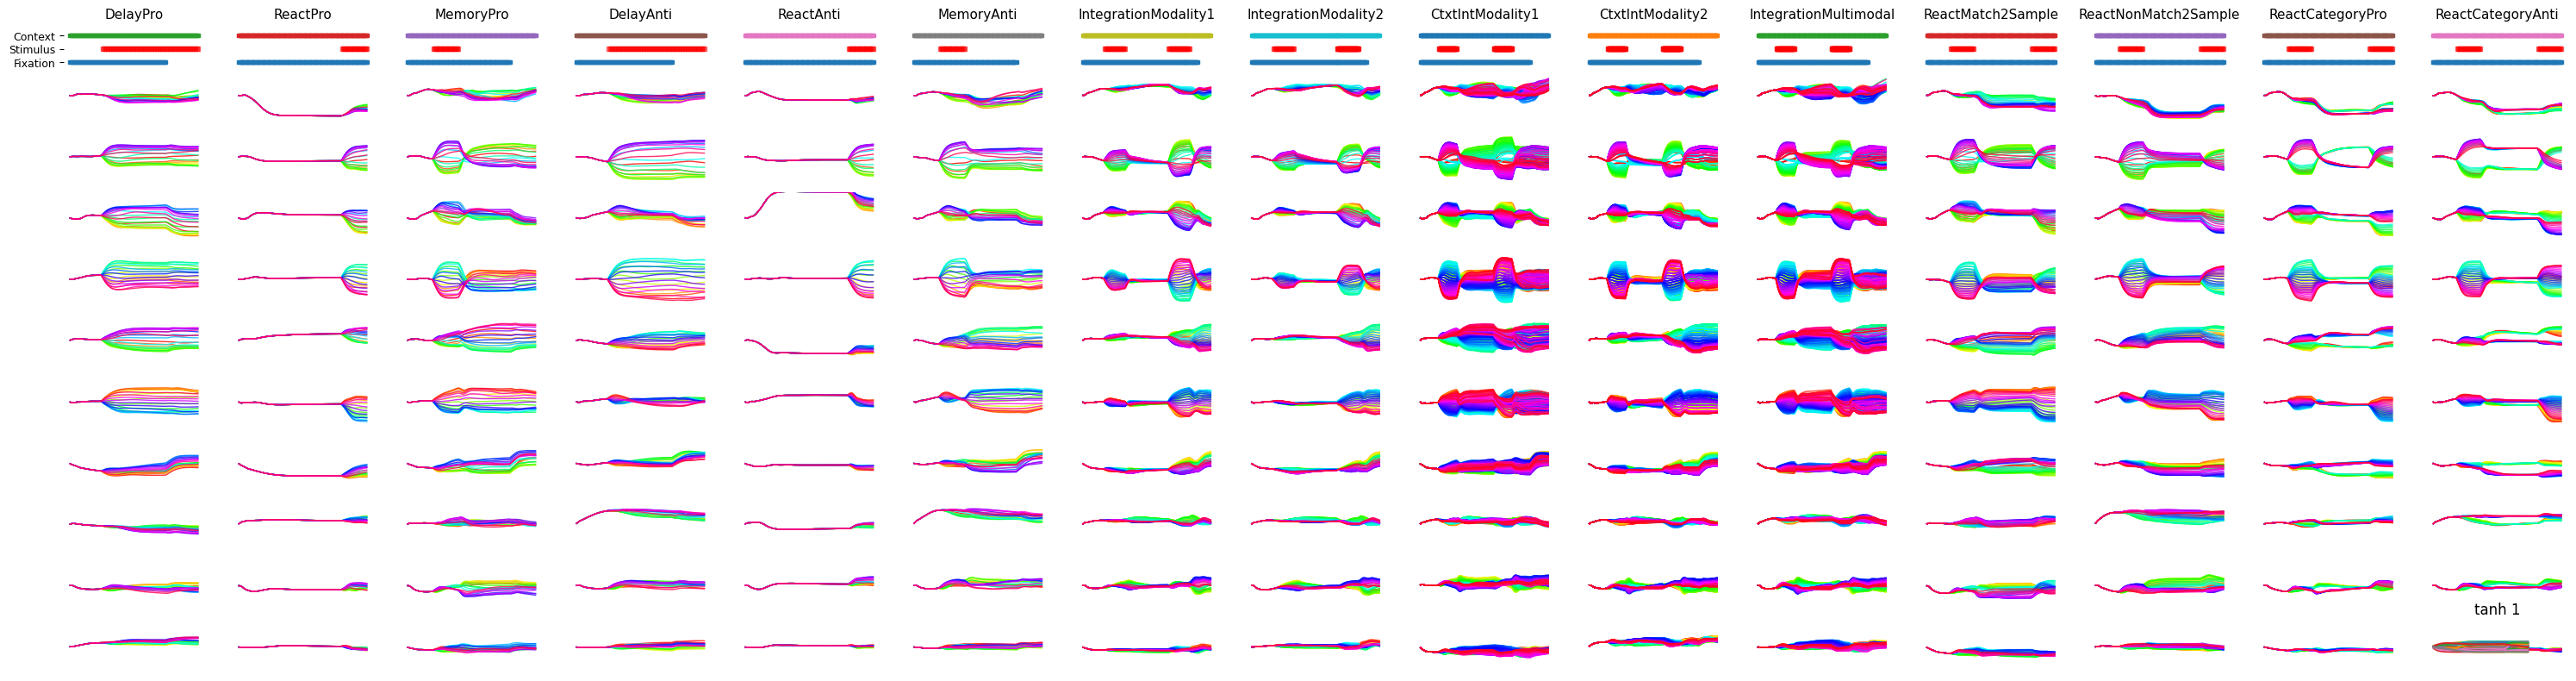

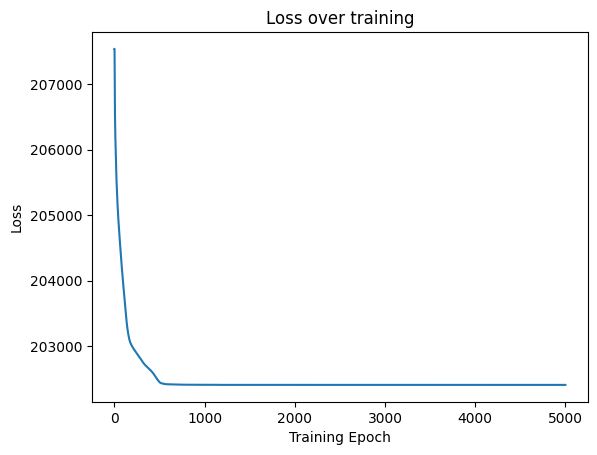

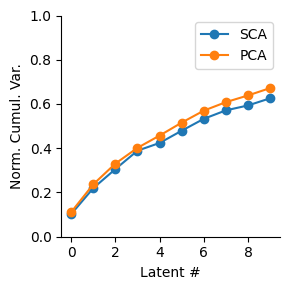

<Figure size 1800x900 with 0 Axes>

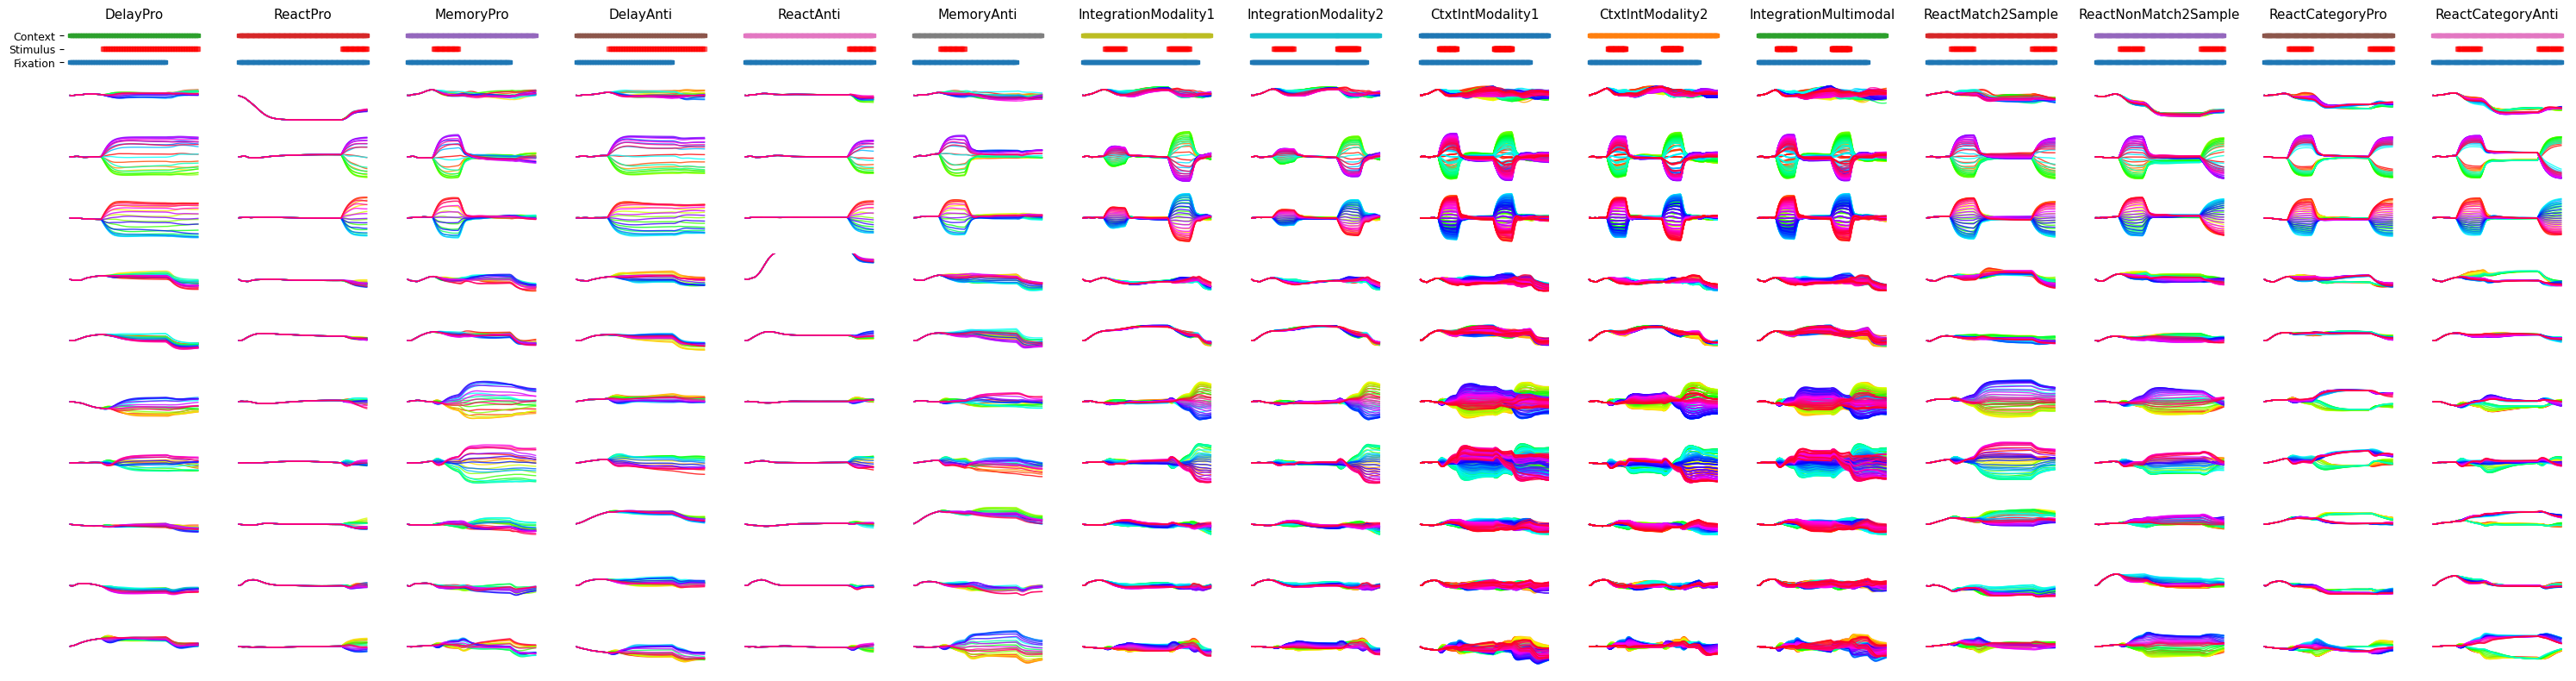

<Figure size 1800x900 with 0 Axes>

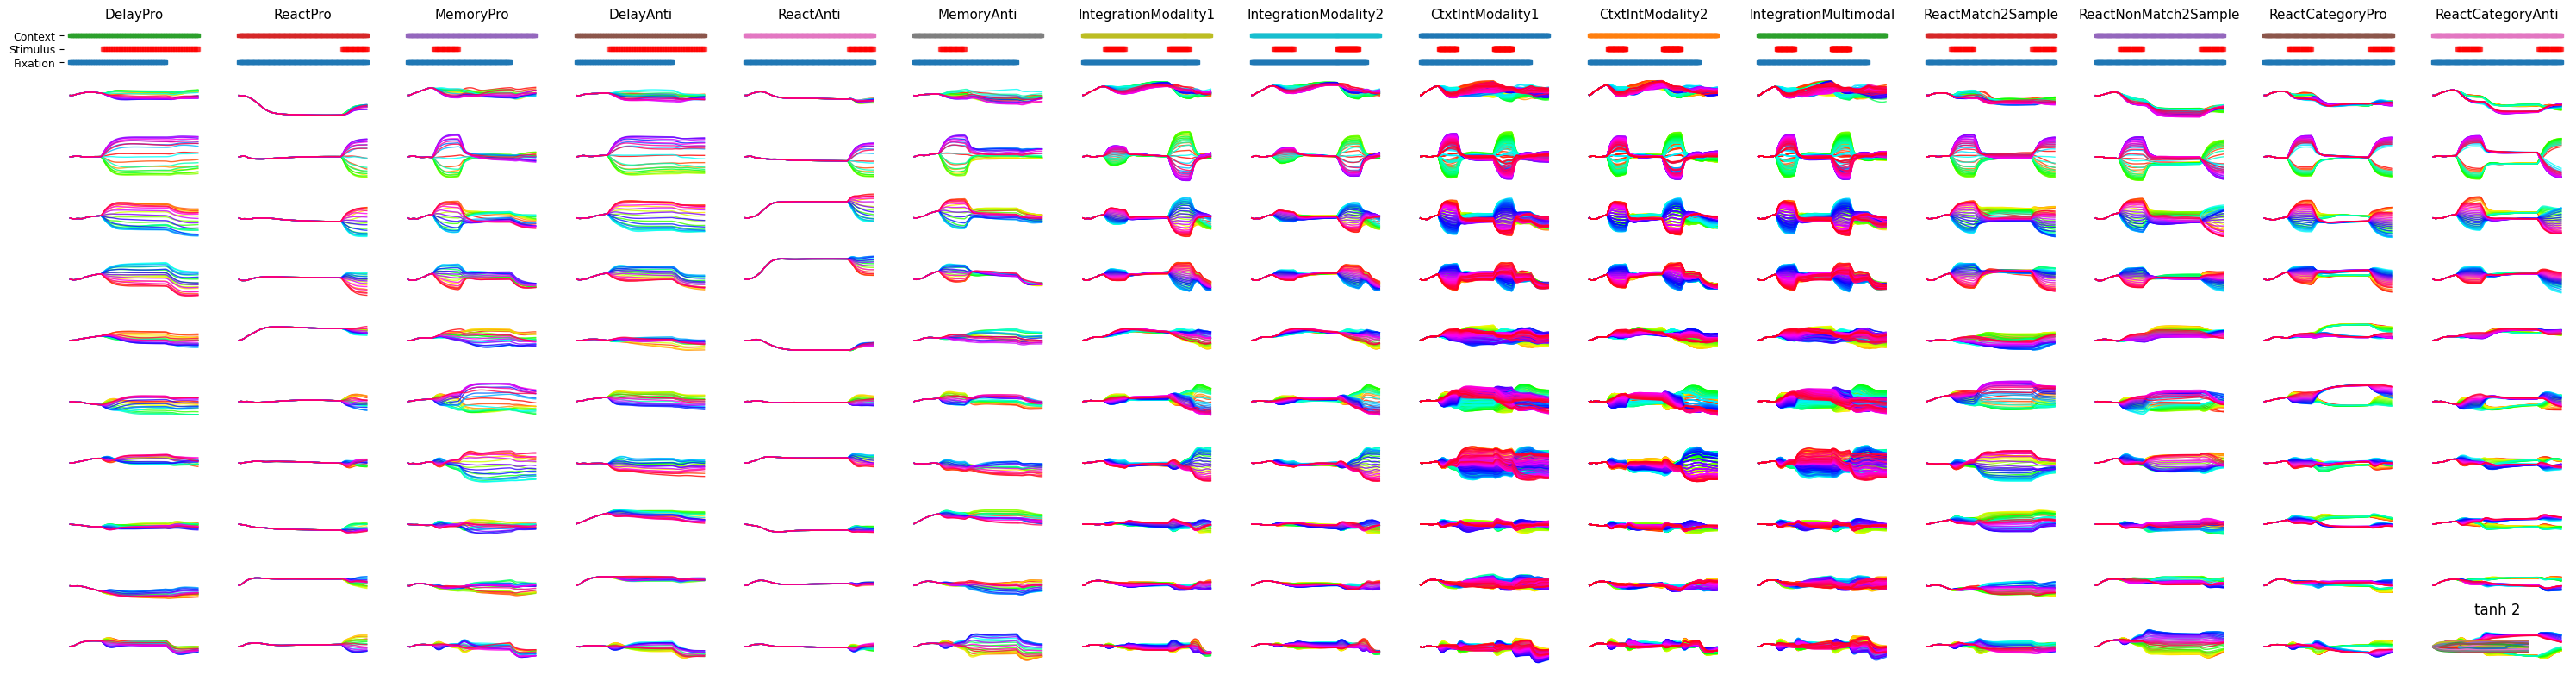

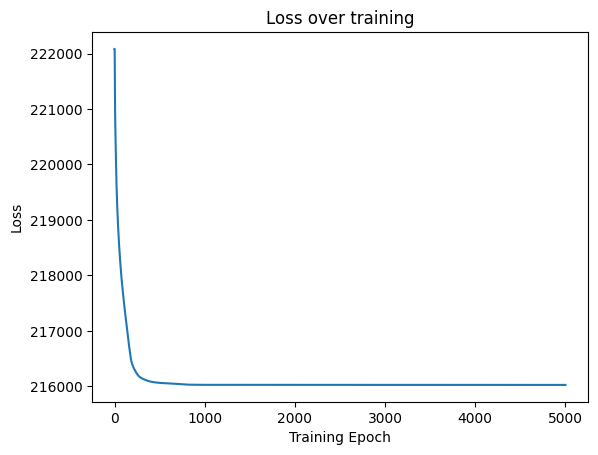

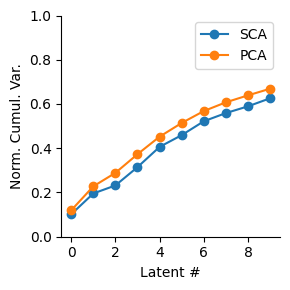

<Figure size 1800x900 with 0 Axes>

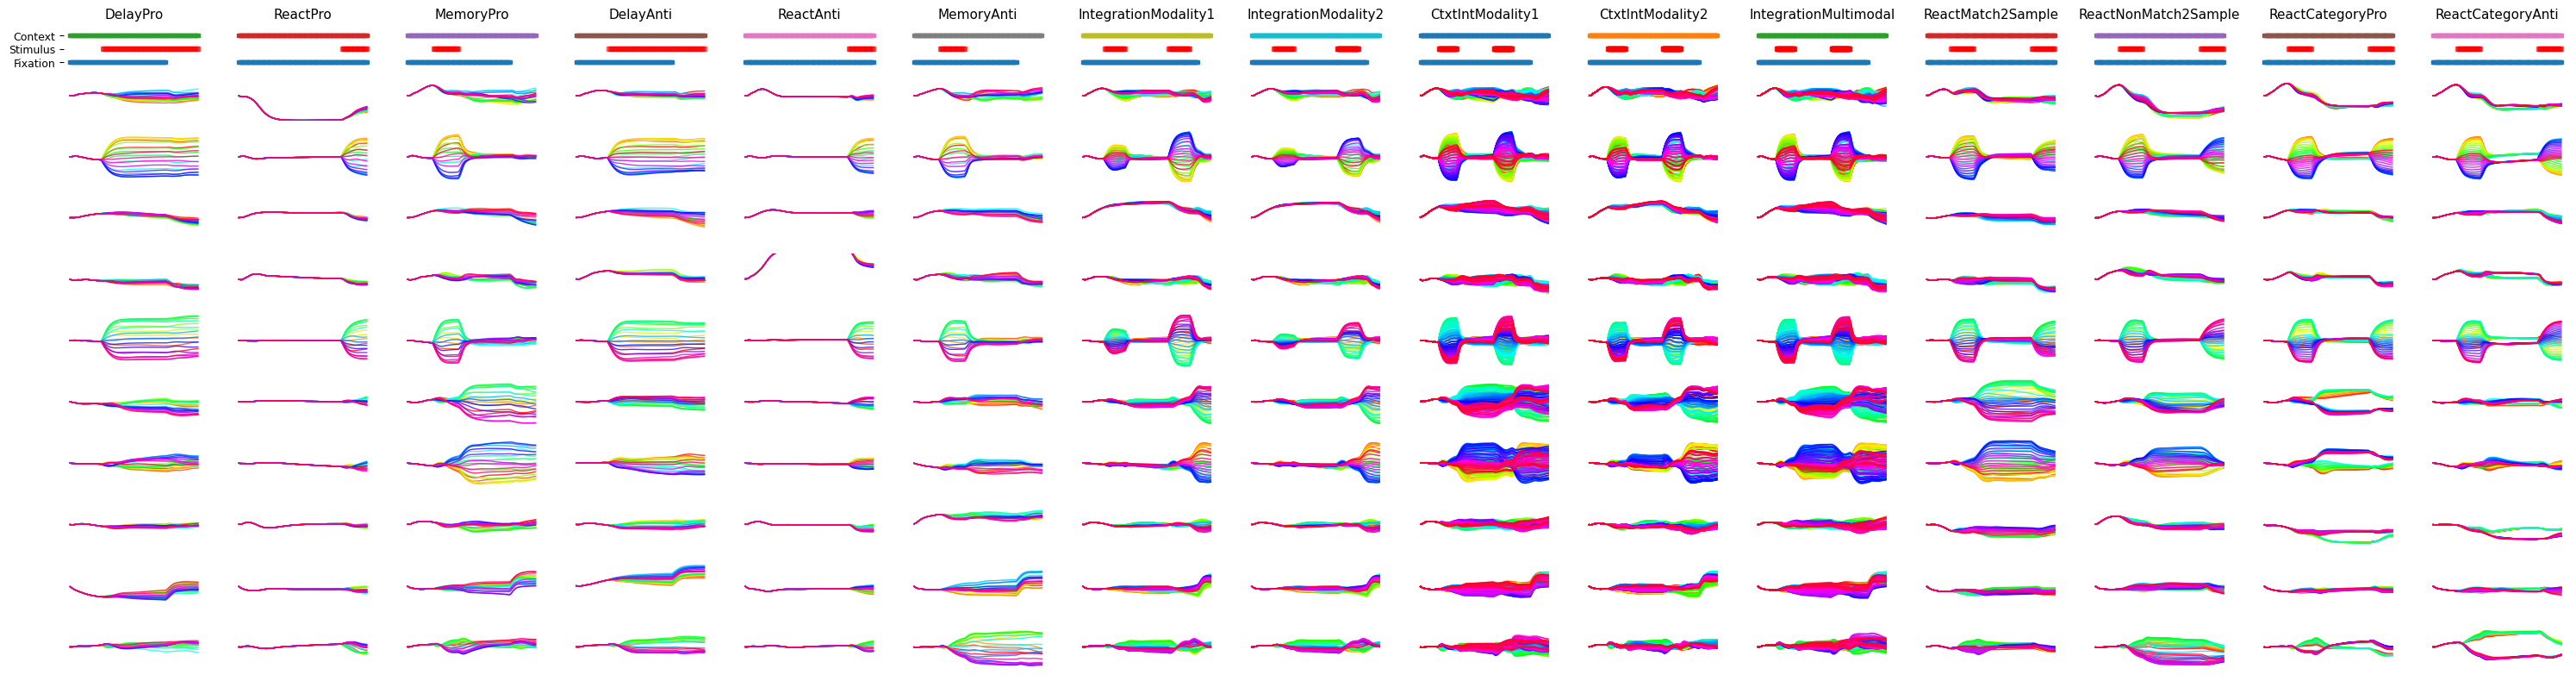

<Figure size 1800x900 with 0 Axes>

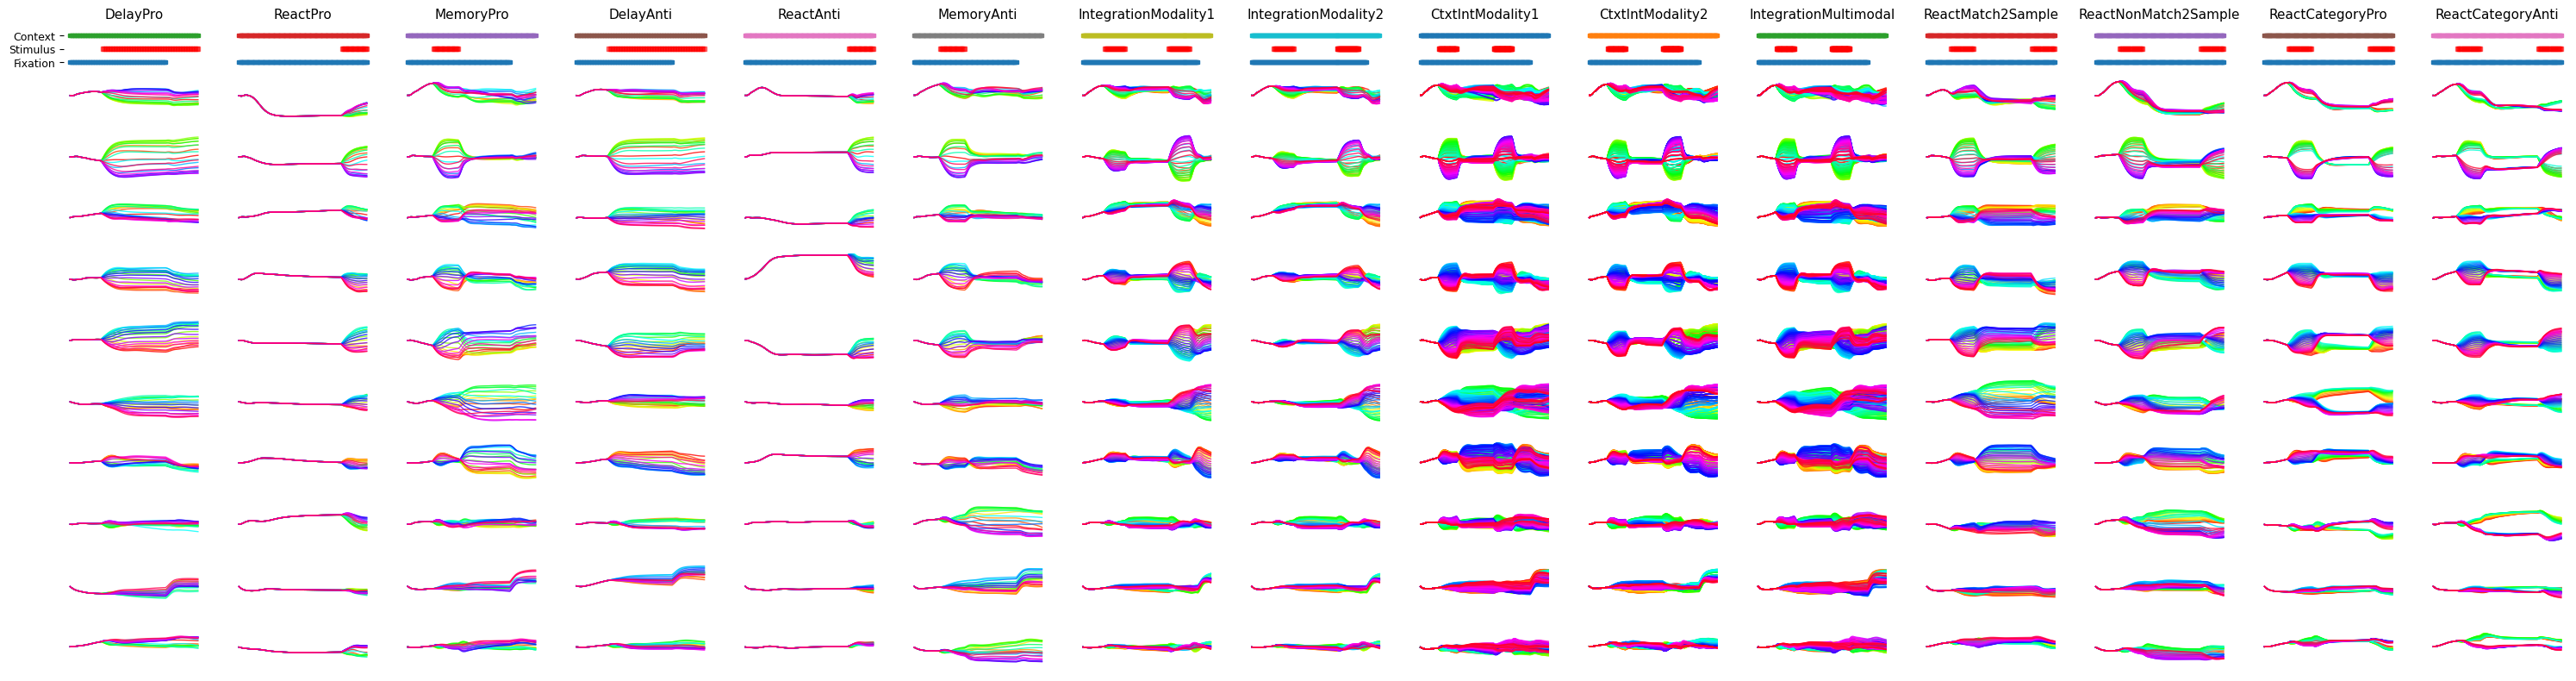

In [21]:
#N latents
R_est=10
R_sim=9

#order of tasks for plotting
rule_sublist = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

#['fdgo','delaygo','fdanti','delayanti','reactgo','reactanti']

rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'CtxtIntModality1', 'CtxtIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

#['DelayPro', 'MemoryPro', 'DelayAnti', 'MemoryAnti', 'ReactPro', 'ReactAnti']

#Number of epochs of model fitting
n_epochs=5000

#Learning rate of model fitting
lr=.001

#Strength of the sparsity penalty
lam_sparse=.1

#Strength of the orthogonality penality (Note - This is only used in the version without a hard orthogonality constraint)
lam_orthog=1

#load task inputs
tanh_m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/tanh/diag/15_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff1.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
trial_all = np.load(os.path.join(tanh_m,'trial_all.npz'),encoding='bytes',allow_pickle=True)

#network params
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -8
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']
rule_trains_str = '_'.join(rule_trains)

rnn_type_set = ['LeakyRNN',]
activation_set = ['tanh','softplus']
w_init_set = ['diag',]
seed_set = [str(0),str(1),str(2),]

activation = 'tanh'

for seed in seed_set:


    m = os.path.join(tanh_m[:-1],str(seed))
    save_m = m[69:]
    save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca_latents',save_m)

    #load network activations
    h_all = np.load(os.path.join(m,'h_all.npz'),encoding='bytes',allow_pickle=True)

    #concatenate activation for each task
    B = np.shape(h_all['by_rule'].item()[rule_sublist[0]])[1]
    cat_h_all_by_rule = h_all['by_rule'].item()[rule_sublist[0]][:,0:B:int(np.round(B/20)),:]
    for rule in rule_sublist[1:]:
        B = np.shape(h_all['by_rule'].item()[rule])[1]
        cat_h_all_by_rule = np.concatenate((cat_h_all_by_rule,h_all['by_rule'].item()[rule][:,0:B:int(np.round(B/20)),:]),axis = 0)

    cat_trials = np.reshape(np.transpose(cat_h_all_by_rule,(1,0,2)),(-1,128))

    #currently using all units
    active_units = np.argsort(np.var(cat_trials,axis = 0))#[:86] # active_units = np.var(cat_trials,axis = 0)>.05

    #plot activations
    plt.plot(cat_trials[:100,active_units],'-')
    plt.xlabel('Time in Trial')
    plt.ylabel('Activation')
    plt.title(activation+' '+str(seed))

    X0 = cat_trials[:,active_units]
    X=np.copy(X0-np.mean(X0,axis=0)[None,:])

    #How much to weight each data point in time
    #(this can be helpful for making sure dimensions still aim to explain time points with low activity)
    sample_weights=get_sample_weights(X) #Weight inversely to norm of activity at each time point

    #Fit weighted PCA
    #Note that this function does not automatically subtract the mean from the data (as in many PCA functions)
    U_est_pca,V_est_pca = weighted_pca(X,R_est,sample_weights)

    #Get the low dimensional representation (the principal components)
    pca_latent = X@U_est_pca
    pca_var = np.var(pca_latent,axis = 0)

    pca_latents = h_all['by_rule'].item()[rule][:,:,active_units]@U_est_pca
    n_time,n_trial,n_latent = np.shape(pca_latents)

    # Fit SCA with orthogonality penalty (rather than constraint) without all the optional parameters
    model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,n_epochs=n_epochs,sample_weight=sample_weights)

    #Get the low dimensional representation
    sca_latent=latent.detach().numpy()
    sca_var = np.var(sca_latent,axis = 0)

    #Plot the loss over all iterations
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over training')
    print(m)

    plot_skree(sca_var,pca_var)

    if activation=='tanh':
        ylim = 5
    else:
        ylim = 1.5

    plot_latents(h_all,trial_all,active_units,R_est,model,U_est_pca,rule_sublist,save_m,ylim)

#                 use = [key[0] in rule_sublist for key in h_all['by_epoch'].item().keys()]
#                 tick_names = [rule_name[key[0]]+' '+str(key[1])[1:][1:-1] for key in h_all['by_epoch'].item().keys()]
#                 ticks_use = [tick_names[x] for x in np.where(use)[0]]

#                 # _, _, n_units = np.shape(h_all['by_rule'].item()[rule])
#                 n_units = len(active_units)# np.sum(active_units>0)
#                 n_task_periods = np.sum(use) #len(h_all['by_epoch'].item().keys())

#                 h_var_all = np.zeros((n_units, n_task_periods))
#                 sca_var_all = np.zeros((n_latent, n_task_periods))
#                 pca_var_all = np.zeros((n_latent, n_task_periods))

#                 counter = 0
#                 for i, val in enumerate(h_all['by_epoch'].item().values()):
#                     # val is Time, Batch, Units
#                     # Variance across time and stimulus
#                     # h_var_all[:, i] = val[t_start:].reshape((-1, n_hidden)).var(axis=0)
#                     # Variance acros stimulus, then averaged across time

#                     if use[i]==True:

#                         active_val = val[:,:,active_units]

#                         val_reshape = np.reshape(active_val,(-1,n_units))
#                         h_var_all[:, counter] = val_reshape.var(axis = 0)

#                         sca_val = np.dot(active_val,model.fc2.weight.detach().numpy())
#                         sca_val_reshape = np.reshape(sca_val,(-1,n_latent))
#                         sca_var_all[:, counter] = sca_val_reshape.var(axis = 0)

#                         pca_val = active_val@U_est_pca
#                         pca_val_reshape = np.reshape(pca_val,(-1,n_latent))
#                         pca_var_all[:, counter] = pca_val_reshape.var(axis = 0)

#                         counter+=1

#                 pca_normvar_all = (pca_var_all.T/np.max(pca_var_all, axis=1)).T
#                 D = pca_normvar_all.T
#                 pca_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0, 
#                                               max_d = 2,fig_width = 2.5,fig_height = 5)

#                 sca_normvar_all = (sca_var_all.T/np.max(sca_var_all, axis=1)).T
#                 D = sca_normvar_all.T
#                 sca_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0,
#                                               max_d = 2,fig_width = 2.5,fig_height = 5)

#                 h_normvar_all = (h_var_all.T/np.max(h_var_all, axis=1)).T
#                 D = h_normvar_all.T
#                 h_cluster_var = make_dendro(D,ticks_use,method = 'ward',criterion = 'maxclust',cel_max_d = 0,
#                                               max_d = 0,fig_width = 2.5,fig_height = 5)

#                 sca_X_diff,pca_X_diff =  plot_atlas(sca_normvar_all,sca_cluster_var,pca_normvar_all,pca_cluster_var,tick_names)

#                 label = '_'.join([activation,'seed'+str(seed),'nlatent'+str(R_est)])
#                 save_dir = os.path.join('/Users/lauradriscoll/Documents/sca_new/',label)
#                 if not os.path.exists(save_dir):
#                     os.makedirs(save_dir)

#                 # new var Josh asked for
#                 np.save(os.path.join(save_dir,'model_weights'),model.fc2.weight.detach().numpy())
#                 shutil.copy(os.path.join(m,'h_all.npz'), os.path.join(save_dir,'h_all.npz'))

#                 #save atlas var
#                 atlas_var = {'pca_normvar_all':pca_normvar_all,
#                           'pca_cluster_var':pca_cluster_var,
#                           'sca_normvar_all':sca_normvar_all,
#                           'sca_cluster_var':sca_cluster_var,
#                           'h_normvar_all':h_normvar_all,
#                           'h_cluster_var':h_cluster_var}

#                 np.savez(os.path.join(save_dir,'atlas_var.npz'),**atlas_var)


#                 #save_sca var
#                 sca_var = {'cat_trials':cat_trials,
#                           'X':X,
#                           'latent':sca_latent}

#                 np.savez(os.path.join(save_dir,'sca_var.npz'),**sca_var)

#                 #Save Diff summary variables
#                 X_diff = {'sca':sca_X_diff,
#                           'pca':pca_X_diff}

#                 figname = 'X_diff_'+label

#                 np.savez(os.path.join(save_dir,figname+'.npz'),**X_diff)
# #                 np.savez(os.path.join(save_dir,'h_all.npz'),encoding='bytes',allow_pickle=True)



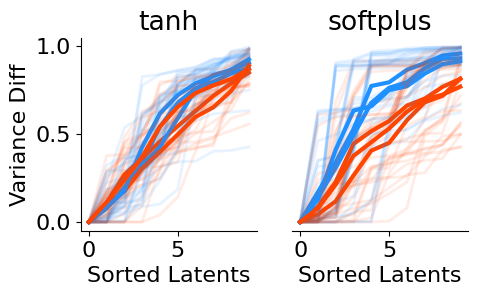

In [42]:
fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

activation_set = ['tanh','softplus'] 

for activation in activation_set:
    
    if activation==activation_set[0]:
        plt.sca(ax1)
    else:
        plt.sca(ax2)
            
    for seed in ['0','1','2']:

        label = '_'.join([activation,'seed'+seed,'nlatent'+str(R_est)])
        figname = 'X_diff_'+label

        X_diff = np.load(os.path.join(save_dir,figname+'.npz'))

        mean_x_diff = np.mean(np.sort(X_diff['sca'],axis = 0),axis = 1)
        plt.plot(mean_x_diff,linewidth = 3,color = 'dodgerblue')
        plt.plot(np.sort(X_diff['sca'],axis = 0),linewidth = 2,alpha = .1,color = 'dodgerblue')

        mean_x_diff = np.mean(np.sort(X_diff['pca'],axis = 0),axis = 1)
        plt.plot(mean_x_diff,linewidth = 3,color = 'orangered')
        plt.plot(np.sort(X_diff['pca'],axis = 0),linewidth = 2,alpha = .1,color = 'orangered')
        
    plt.xlabel('Sorted Latents')
    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])
    
ax1.set_title(activation_set[0])
ax2.set_title(activation_set[1])
ax1.set_ylabel('Variance Diff')


figpath_full = '/Users/lauradriscoll/Documents/sca/summary_figs'
if not os.path.exists(figpath_full):
        os.makedirs(figpath_full) 
        
plt.savefig(os.path.join(figpath_full,'var_diff.pdf'),bbox_inches = 'tight')
plt.show()

In [43]:
epoch_set = ['Stimulus1','Stimulus2','Memory1','Memory2','Response']

epoch_b = {}

for e_ind in range(len(epoch_set)):
    epoch_b[epoch_set[e_ind]] = np.zeros(len(epoch_set))
    epoch_b[epoch_set[e_ind]][e_ind] = 1

/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_38684/2373458886.py:117: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,


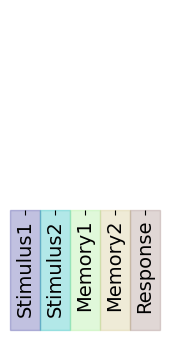

In [45]:
fig = plt.figure(figsize=(1.2,2))
ax = fig.add_axes([0,0,1,1])#fig.add_subplot(1,2,1)
ax.set_xticks(range(len(epoch_set)))
ax.set_xticklabels(epoch_set,fontsize = 14, rotation =90,ha = 'center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
# ax.set_xticks([])
    
plot_epoch_rects(ax,epoch_b,epoch_set,which_axes = 'y', rect_height = 1, rect_width = .6, ll = [-.6,0])
plt.savefig(os.path.join(figpath_full,'epoch_legend.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(figpath_full,'epoch_legend.png'),bbox_inches = 'tight')

/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_38684/3705039983.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath_full,figname),bbox_inches='tight')
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_38684/3705039983.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath_full,figname),bbox_inches='tight')
/var/folders/2h/bdfh74y164bbddrw0dv894fw0000gn/T/ipykernel_38684/3705039983.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath_full,figname),bbox_inches='tight')
/usr/local/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results mi

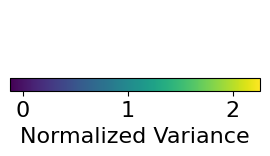

In [46]:
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 2.5, 1])
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')
plt.xlim([0,-.1])
plt.ylim([0,-.1])
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])
cbar = plt.colorbar(orientation="horizontal",fraction=0.5,pad=.5,anchor=(-.15,.5))
cbar.set_label('Normalized Variance')

figname = 'var_legend.pdf'
plt.savefig(os.path.join(figpath_full,figname),bbox_inches='tight')
figname = 'var_legend.png'
plt.savefig(os.path.join(figpath_full,figname),bbox_inches='tight')
plt.show()

In [18]:
###save and load epoch divisions
#get trial in multitask env tensorflow

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']

trial = {}
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    for rule in rule_trains:
        trial[rule] = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)

trial[rule].epochs

save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca','epoch_divisions')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.savez(os.path.join(save_dir,'trial.npz'),**trial)

In [6]:
###save and load epoch divisions
#get trial in multitask env tensorflow

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

trial = {}
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    for rule in rule_trains:
        trial[rule] = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)

trial[rule].y

save_dir = os.path.join('/Users/lauradriscoll/Documents/','sca','target_output')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.savez(os.path.join(save_dir,'target_output.npz'),**trial)

NameError: name 'Model' is not defined

In [26]:
##load variable in sca env py311

trial_epochs = np.load('/Users/lauradriscoll/Documents/sca/epoch_divisions/trial_epochs.npz',allow_pickle=True)

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']
for rule in rule_trains:
    print(rule)
    print(trial_epochs[rule])

fdgo
{'stim1': (25, 75), 'go1': (75, None), 'fix1': (None, 25)}
reactgo
{'go1': (100, None), 'fix1': (None, 100)}
delaygo
{'delay1': (50, 100), 'stim1': (25, 50), 'go1': (100, None), 'fix1': (None, 25)}
fdanti
{'stim1': (25, 75), 'go1': (75, None), 'fix1': (None, 25)}
reactanti
{'go1': (100, None), 'fix1': (None, 100)}
delayanti
{'delay1': (50, 100), 'stim1': (25, 50), 'go1': (100, None), 'fix1': (None, 25)}
